# 05 - EDA y Modelado: Clasificación Mensual de Riesgo

## Descripción del Dataset

Dataset **mensual por municipio** con información de:
- **Lags temporales**: valores de delitos en meses anteriores (1, 3, 12 meses)
- **Rolling windows**: medias y desviaciones móviles (3, 12 meses)
- **Tasas por 100mil hab**: delitos normalizados por población
- **Estacionalidad**: mes_sin, mes_cos, trimestre
- **Cambios porcentuales**: variación vs períodos anteriores
- **Conteo de delitos**: por tipo y total

## Targets

| Target | Tipo | Clases | Uso |
|--------|------|--------|-----|
| `nivel_riesgo` | Multiclase | BAJO, MEDIO, ALTO | Semáforos delictivos |
| `incremento_delitos` | Binario | 0, 1 | Alertas de incremento |

## Preguntas que Responde

1. **¿Qué municipios están en riesgo alto el próximo mes?**
2. **¿En qué municipios aumentarán los delitos?**
3. **¿Qué variables explican el riesgo mensual?**

## Utilidad para el Reto

- **Tablero web**: Semáforos delictivos por municipio
- **Chatbot**: "¿Qué municipios tienen riesgo alto en enero?"
- **Alertas**: Identificar municipios donde aumentarán delitos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 50)

# Rutas
BASE_DIR = Path().resolve().parent
DATA_PATH = BASE_DIR / 'data' / 'gold' / 'model' / 'classification_monthly_dataset.parquet'

In [2]:
# Cargar datos
df = pd.read_parquet(DATA_PATH)
print(f"Shape: {df.shape}")
print(f"\nColumnas: {df.columns.tolist()}")
df.head()

Shape: (13044, 62)

Columnas: ['codigo_departamento', 'area', 'codigo_municipio', 'Shape_Leng', 'Shape_Area', 'n_centros_poblados', 'anio', 'mes', 'total_delitos', 'ABIGEATO', 'AMENAZAS', 'DELITOS SEXUALES', 'EXTORSION', 'HOMICIDIOS', 'HURTOS', 'LESIONES', 'VIOLENCIA INTRAFAMILIAR', 'femenino_adolescentes', 'femenino_adultos', 'femenino_menores', 'masculino_adolescentes', 'masculino_adultos', 'masculino_menores', 'poblacion_total', 'poblacion_menores', 'poblacion_adultos', 'poblacion_adolescentes', 'area_km2', 'densidad_poblacional', 'centros_por_km2', 'proporcion_menores', 'proporcion_adultos', 'proporcion_adolescentes', 'fecha', 'trimestre', 'es_fin_ano', 'n_dias_semana', 'n_fines_de_semana', 'n_festivos', 'n_dias_laborales', 'tasa_abigeato', 'tasa_amenazas', 'tasa_delitos sexuales', 'tasa_extorsion', 'tasa_homicidios', 'tasa_hurtos', 'tasa_lesiones', 'tasa_violencia intrafamiliar', 'mes_sin', 'mes_cos', 'lag_1', 'lag_3', 'lag_12', 'roll_mean_3', 'roll_mean_12', 'roll_std_3', 'roll_s

,codigo_departamento,area,codigo_municipio,Shape_Leng,Shape_Area,n_centros_poblados,anio,mes,total_delitos,ABIGEATO,AMENAZAS,DELITOS SEXUALES,EXTORSION,HOMICIDIOS,HURTOS,LESIONES,VIOLENCIA INTRAFAMILIAR,femenino_adolescentes,femenino_adultos,femenino_menores,masculino_adolescentes,masculino_adultos,masculino_menores,poblacion_total,poblacion_menores,...,n_fines_de_semana,n_festivos,n_dias_laborales,tasa_abigeato,tasa_amenazas,tasa_delitos sexuales,tasa_extorsion,tasa_homicidios,tasa_hurtos,tasa_lesiones,tasa_violencia intrafamiliar,mes_sin,mes_cos,lag_1,lag_3,lag_12,roll_mean_3,roll_mean_12,roll_std_3,roll_std_12,pct_change_1,pct_change_3,pct_change_12,nivel_riesgo,incremento_delitos
0,68,152.915686,68001,0.693489,0.012514,1,2010,1,755.0,0.0,26.0,44.0,3.0,11.0,283.0,283.0,105.0,22835,464037,59928,23336,415519,62405,1048060,122333,...,138,29,301,0.0,2.480774,4.198233,0.286243,1.049558,27.002271,27.002271,10.018510,0.5,0.866025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALTO,0
1,68,152.915686,68001,0.693489,0.012514,1,2010,2,547.0,0.0,11.0,48.0,2.0,14.0,191.0,245.0,36.0,22835,464037,59928,23336,415519,62405,1048060,122333,...,102,0,265,0.0,1.049558,4.579890,0.190829,1.335801,18.224147,23.376524,3.434918,0.866025,0.5,755.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.275497,NaN,NaN,ALTO,0
2,68,152.915686,68001,0.693489,0.012514,1,2010,3,644.0,0.0,21.0,60.0,2.0,13.0,193.0,301.0,54.0,22835,464037,59928,23336,415519,62405,1048060,122333,...,105,10,316,0.0,2.003702,5.724863,0.190829,1.240387,18.414976,28.719730,5.152377,1.0,0.0,547.0,NaN,NaN,648.666667,NaN,104.078496,NaN,0.177331,NaN,NaN,ALTO,1
3,68,152.915686,68001,0.693489,0.012514,1,2010,4,694.0,0.0,47.0,48.0,2.0,8.0,206.0,316.0,67.0,22835,464037,59928,23336,415519,62405,1048060,122333,...,124,21,309,0.0,4.484476,4.579890,0.190829,0.763315,19.655363,30.150946,6.392764,0.866025,-0.5,644.0,755.0,NaN,628.333333,NaN,74.741778,NaN,0.077640,-0.080795,NaN,ALTO,1
4,68,152.915686,68001,0.693489,0.012514,1,2010,5,727.0,0.0,35.0,70.0,2.0,17.0,217.0,299.0,87.0,22835,464037,59928,23336,415519,62405,1048060,122333,...,139,31,314,0.0,3.339503,6.679007,0.190829,1.622045,20.704921,28.528901,8.301051,0.5,-0.866025,694.0,547.0,NaN,688.333333,NaN,41.789153,NaN,0.047550,0.329068,NaN,ALTO,1


In [3]:
# Info general
print("=" * 60)
print("INFO GENERAL")
print("=" * 60)
print(f"\nTotal registros: {len(df):,}")
print(f"Período: {df['anio'].min()} - {df['anio'].max()}")
print(f"Municipios: {df['codigo_municipio'].nunique()}")
print(f"\nValores nulos:")
nulls = df.isnull().sum()
print(nulls[nulls > 0])

INFO GENERAL

Total registros: 13,044
Período: 2010 - 2025
Municipios: 87

Valores nulos:
lag_1              87
lag_3             261
lag_12           1044
roll_mean_3       174
roll_mean_12      957
roll_std_3        174
roll_std_12       957
pct_change_1       87
pct_change_3      261
pct_change_12    1044
dtype: int64


---
## 1. Análisis de los Targets

TARGET 1: NIVEL DE RIESGO

Clases: 3

Distribución:
   MEDIO: 4,563 (35.0%)
   BAJO: 4,359 (33.4%)
   ALTO: 4,122 (31.6%)


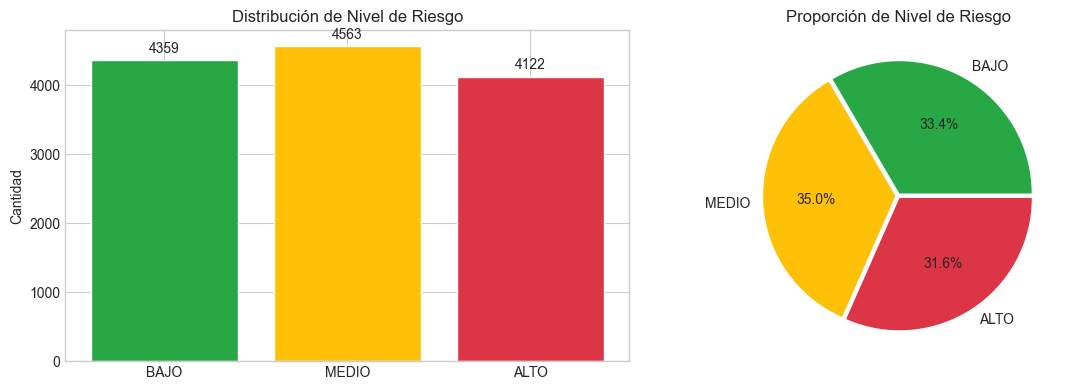


 Balance de clases: Balanceado ✅


In [4]:
# 1.1 Análisis del target: NIVEL DE RIESGO (Multiclase)
print("=" * 60)
print("TARGET 1: NIVEL DE RIESGO")
print("=" * 60)

riesgo_dist = df['nivel_riesgo'].value_counts()
riesgo_pct = (riesgo_dist / len(df) * 100).round(2)

print(f"\nClases: {df['nivel_riesgo'].nunique()}")
print(f"\nDistribución:")
for nivel, count in riesgo_dist.items():
    print(f"   {nivel}: {count:,} ({riesgo_pct[nivel]:.1f}%)")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

colors = {'BAJO': '#28a745', 'MEDIO': '#ffc107', 'ALTO': '#dc3545'}
orden = ['BAJO', 'MEDIO', 'ALTO']

ax1 = axes[0]
bars = ax1.bar([x for x in orden], [riesgo_dist[x] for x in orden], 
               color=[colors[x] for x in orden], edgecolor='white')
ax1.set_title('Distribución de Nivel de Riesgo')
ax1.set_ylabel('Cantidad')
ax1.bar_label(bars, fmt='%d', padding=3)

ax2 = axes[1]
ax2.pie([riesgo_dist[x] for x in orden], labels=orden, autopct='%1.1f%%',
        colors=[colors[x] for x in orden], explode=[0.02]*3)
ax2.set_title('Proporción de Nivel de Riesgo')

plt.tight_layout()
plt.show()

print(f"\n Balance de clases: {'Balanceado ✅' if max(riesgo_pct) - min(riesgo_pct) < 10 else 'Desbalanceado ⚠️'}")

TARGET 2: INCREMENTO DE DELITOS

Clases: 2
Registros válidos: 13,044 (sin nulos)

Distribución:
   No incrementó (0): 7,585 (58.1%)
   Incrementó (1): 5,459 (41.9%)


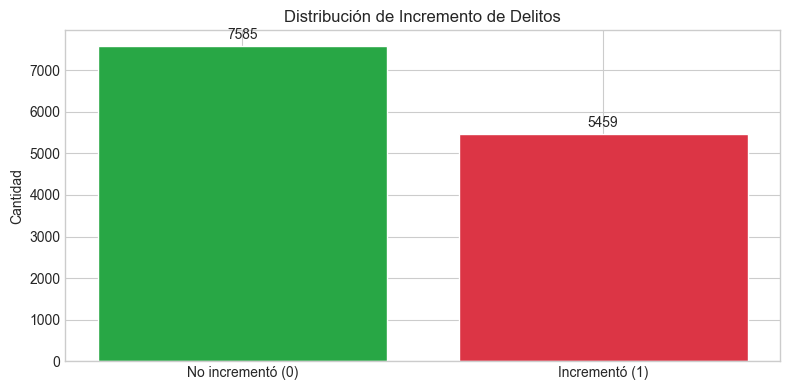


 Ratio positivos/negativos: 0.72
 Balance: Desbalanceado ⚠️


In [5]:
# 1.2 Análisis del target: INCREMENTO DE DELITOS (Binario)
print("=" * 60)
print("TARGET 2: INCREMENTO DE DELITOS")
print("=" * 60)

# Eliminar nulos para este análisis
df_incr = df.dropna(subset=['incremento_delitos'])
incr_dist = df_incr['incremento_delitos'].value_counts()
incr_pct = (incr_dist / len(df_incr) * 100).round(2)

print(f"\nClases: {df_incr['incremento_delitos'].nunique()}")
print(f"Registros válidos: {len(df_incr):,} (sin nulos)")
print(f"\nDistribución:")
for val, count in incr_dist.items():
    label = "Incrementó" if val == 1 else "No incrementó"
    print(f"   {label} ({int(val)}): {count:,} ({incr_pct[val]:.1f}%)")

# Visualización
fig, ax = plt.subplots(figsize=(8, 4))
colors_bin = {0: '#28a745', 1: '#dc3545'}
labels_bin = ['No incrementó (0)', 'Incrementó (1)']
bars = ax.bar(labels_bin, [incr_dist[0], incr_dist[1]], 
              color=[colors_bin[0], colors_bin[1]], edgecolor='white')
ax.set_title('Distribución de Incremento de Delitos')
ax.set_ylabel('Cantidad')
ax.bar_label(bars, fmt='%d', padding=3)
plt.tight_layout()
plt.show()

ratio = incr_dist[1] / incr_dist[0]
print(f"\n Ratio positivos/negativos: {ratio:.2f}")
print(f" Balance: {'Balanceado ✅' if 0.8 < ratio < 1.2 else 'Desbalanceado ⚠️'}")

RELACIÓN ENTRE TARGETS

 % de Incremento por Nivel de Riesgo:
   BAJO: 14.4% incrementaron
   MEDIO: 54.0% incrementaron
   ALTO: 57.4% incrementaron


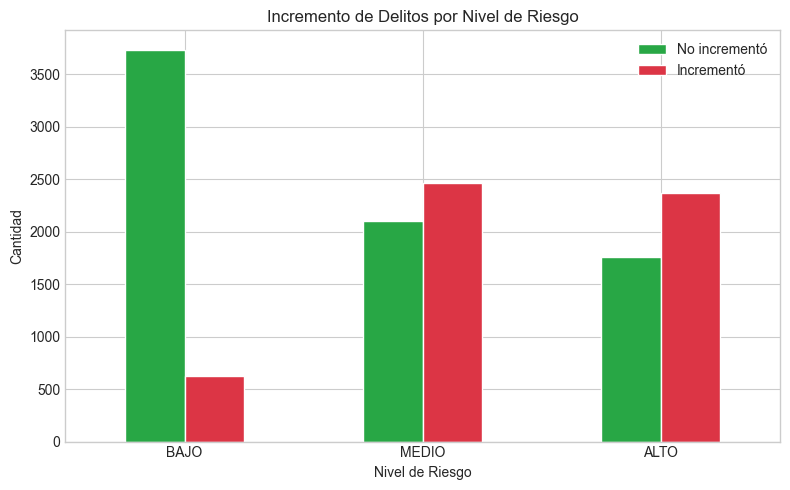

In [6]:
# 1.3 Relación entre targets
print("=" * 60)
print("RELACIÓN ENTRE TARGETS")
print("=" * 60)

# Crosstab
df_valid = df.dropna(subset=['incremento_delitos'])
cross = pd.crosstab(df_valid['nivel_riesgo'], df_valid['incremento_delitos'], normalize='index') * 100

print("\n % de Incremento por Nivel de Riesgo:")
for nivel in ['BAJO', 'MEDIO', 'ALTO']:
    if nivel in cross.index:
        pct_incr = cross.loc[nivel, 1] if 1 in cross.columns else 0
        print(f"   {nivel}: {pct_incr:.1f}% incrementaron")

# Visualización
fig, ax = plt.subplots(figsize=(8, 5))
cross_abs = pd.crosstab(df_valid['nivel_riesgo'], df_valid['incremento_delitos'])
cross_abs = cross_abs.reindex(['BAJO', 'MEDIO', 'ALTO'])
cross_abs.plot(kind='bar', ax=ax, color=['#28a745', '#dc3545'], edgecolor='white')
ax.set_title('Incremento de Delitos por Nivel de Riesgo')
ax.set_xlabel('Nivel de Riesgo')
ax.set_ylabel('Cantidad')
ax.legend(['No incrementó', 'Incrementó'])
ax.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

---
## 2. Análisis de Features

In [7]:
# 2.1 Clasificar features por tipo
print("=" * 60)
print("CLASIFICACIÓN DE FEATURES")
print("=" * 60)

# Columnas a excluir (no features)
cols_excluir = ['nivel_riesgo', 'incremento_delitos', 'fecha', 'codigo_departamento']

# Agrupar features por categoría
features_temporales = ['anio', 'mes', 'trimestre', 'es_fin_ano', 'n_dias_semana', 
                       'n_fines_de_semana', 'n_festivos', 'n_dias_laborales', 'mes_sin', 'mes_cos']

features_lags = ['lag_1', 'lag_3', 'lag_12']

features_rolling = ['roll_mean_3', 'roll_mean_12', 'roll_std_3', 'roll_std_12']

features_pct_change = ['pct_change_1', 'pct_change_3', 'pct_change_12']

features_delitos = ['total_delitos', 'ABIGEATO', 'AMENAZAS', 'DELITOS SEXUALES', 'EXTORSION', 
                    'HOMICIDIOS', 'HURTOS', 'LESIONES', 'VIOLENCIA INTRAFAMILIAR']

features_tasas = [c for c in df.columns if c.startswith('tasa_')]

features_geo = ['codigo_municipio', 'area', 'Shape_Leng', 'Shape_Area', 'n_centros_poblados',
                'area_km2', 'densidad_poblacional', 'centros_por_km2']

features_poblacion = ['poblacion_total', 'poblacion_menores', 'poblacion_adultos', 'poblacion_adolescentes',
                      'femenino_adolescentes', 'femenino_adultos', 'femenino_menores',
                      'masculino_adolescentes', 'masculino_adultos', 'masculino_menores',
                      'proporcion_menores', 'proporcion_adultos', 'proporcion_adolescentes']

print(f"\n Resumen de features por categoría:")
print(f"    Temporales: {len(features_temporales)}")
print(f"    Lags: {len(features_lags)}")
print(f"    Rolling: {len(features_rolling)}")
print(f"    Pct Change: {len(features_pct_change)}")
print(f"    Delitos: {len(features_delitos)}")
print(f"    Tasas: {len(features_tasas)}")
print(f"    Geográficas: {len(features_geo)}")
print(f"    Población: {len(features_poblacion)}")

# Features con nulos
print(f"\n⚠️ Features con valores nulos:")
nulls = df.isnull().sum()
for col, count in nulls[nulls > 0].items():
    print(f"   {col}: {count:,} ({count/len(df)*100:.1f}%)")

CLASIFICACIÓN DE FEATURES

 Resumen de features por categoría:
    Temporales: 10
    Lags: 3
    Rolling: 4
    Pct Change: 3
    Delitos: 9
    Tasas: 8
    Geográficas: 8
    Población: 13

⚠️ Features con valores nulos:
   lag_1: 87 (0.7%)
   lag_3: 261 (2.0%)
   lag_12: 1,044 (8.0%)
   roll_mean_3: 174 (1.3%)
   roll_mean_12: 957 (7.3%)
   roll_std_3: 174 (1.3%)
   roll_std_12: 957 (7.3%)
   pct_change_1: 87 (0.7%)
   pct_change_3: 261 (2.0%)
   pct_change_12: 1,044 (8.0%)


ANÁLISIS TEMPORAL


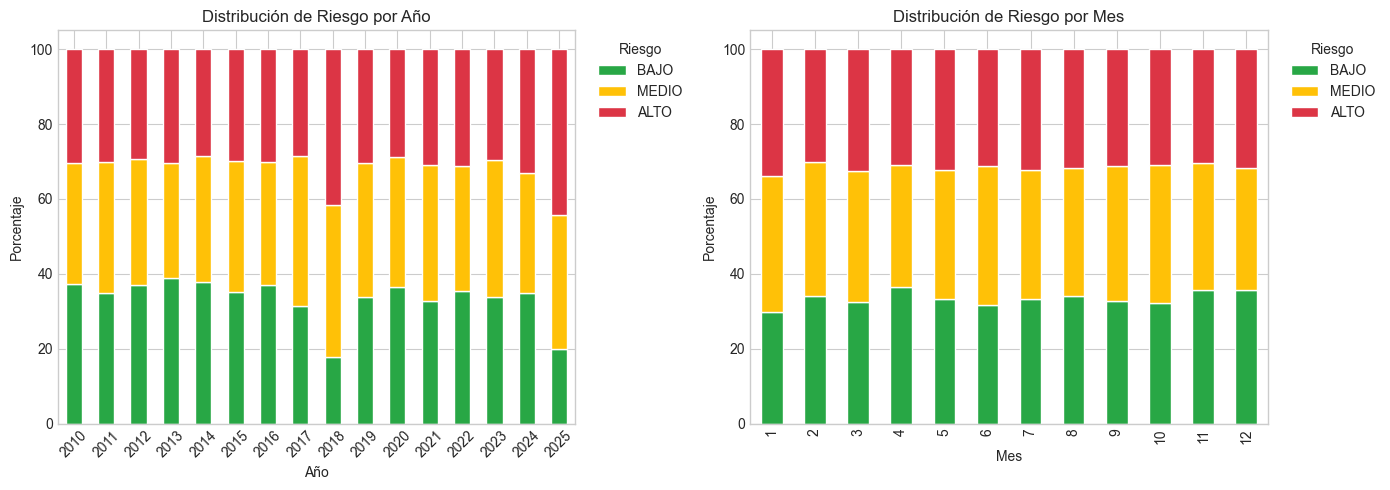


 % de Riesgo ALTO por año:
   2021: 30.9%
   2022: 31.2%
   2023: 29.7%
   2024: 33.0%
   2025: 44.2%


In [8]:
# 2.2 Análisis temporal: Riesgo por año y mes
print("=" * 60)
print("ANÁLISIS TEMPORAL")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Riesgo por año
ax1 = axes[0]
riesgo_anio = pd.crosstab(df['anio'], df['nivel_riesgo'], normalize='index') * 100
riesgo_anio = riesgo_anio[['BAJO', 'MEDIO', 'ALTO']]
riesgo_anio.plot(kind='bar', stacked=True, ax=ax1, 
                  color=['#28a745', '#ffc107', '#dc3545'], edgecolor='white')
ax1.set_title('Distribución de Riesgo por Año')
ax1.set_xlabel('Año')
ax1.set_ylabel('Porcentaje')
ax1.legend(title='Riesgo', bbox_to_anchor=(1.02, 1))
ax1.tick_params(axis='x', rotation=45)

# Riesgo por mes
ax2 = axes[1]
riesgo_mes = pd.crosstab(df['mes'], df['nivel_riesgo'], normalize='index') * 100
riesgo_mes = riesgo_mes[['BAJO', 'MEDIO', 'ALTO']]
riesgo_mes.plot(kind='bar', stacked=True, ax=ax2,
                color=['#28a745', '#ffc107', '#dc3545'], edgecolor='white')
ax2.set_title('Distribución de Riesgo por Mes')
ax2.set_xlabel('Mes')
ax2.set_ylabel('Porcentaje')
ax2.legend(title='Riesgo', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()

# Estadísticas
print(f"\n % de Riesgo ALTO por año:")
for anio in sorted(df['anio'].unique())[-5:]:
    pct_alto = riesgo_anio.loc[anio, 'ALTO']
    print(f"   {anio}: {pct_alto:.1f}%")

CORRELACIÓN CON NIVEL DE RIESGO

 Top 15 features más correlacionadas con nivel_riesgo:
    1. tasa_hurtos: +0.399
    2. tasa_lesiones: +0.395
    3. poblacion_total: +0.368
    4. n_fines_de_semana: +0.366
    5. DELITOS SEXUALES: +0.361
    6. roll_std_12: +0.352
    7. n_dias_semana: +0.345
    8. HOMICIDIOS: +0.344
    9. n_dias_laborales: +0.342
   10. LESIONES: +0.338
   11. roll_std_3: +0.336
   12. total_delitos: +0.325
   13. VIOLENCIA INTRAFAMILIAR: +0.324
   14. roll_mean_3: +0.321
   15. roll_mean_12: +0.320


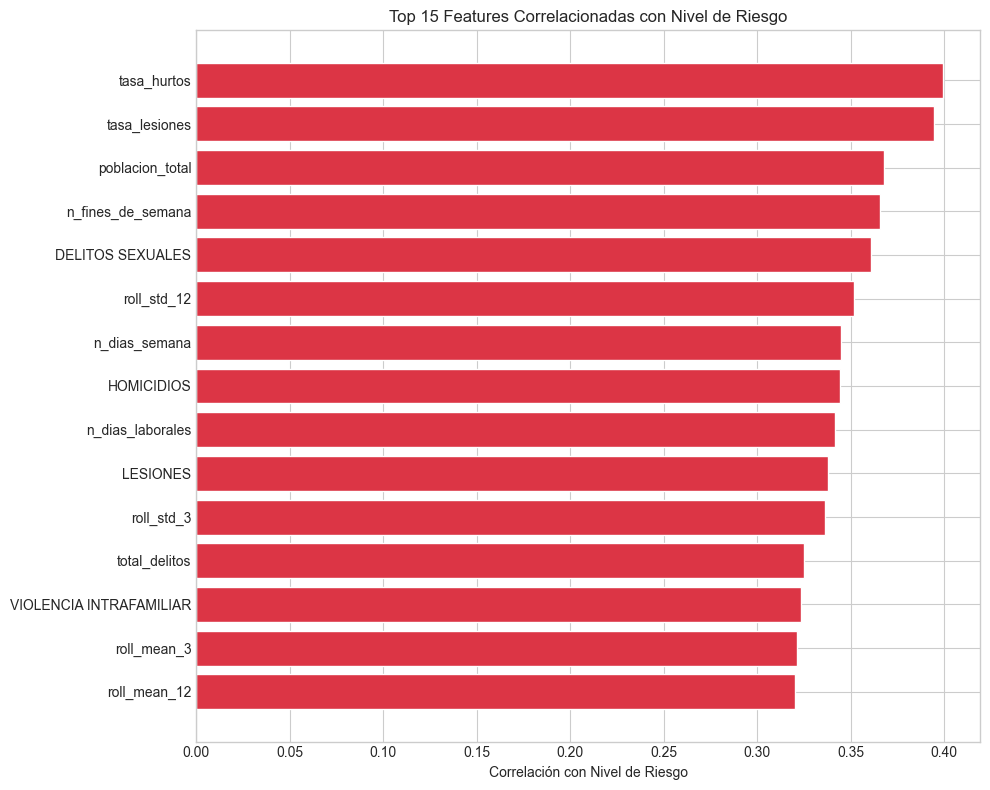

In [9]:
# 2.3 Correlación con el target nivel_riesgo
print("=" * 60)
print("CORRELACIÓN CON NIVEL DE RIESGO")
print("=" * 60)

# Convertir nivel_riesgo a numérico para correlación
df_corr = df.copy()
riesgo_map = {'BAJO': 0, 'MEDIO': 1, 'ALTO': 2}
df_corr['nivel_riesgo_num'] = df_corr['nivel_riesgo'].map(riesgo_map)

# Seleccionar features numéricas
features_num = features_temporales + features_lags + features_rolling + features_pct_change + \
               features_delitos + features_tasas + ['densidad_poblacional', 'poblacion_total']
features_num = [f for f in features_num if f in df_corr.columns]

# Calcular correlación
corr_riesgo = df_corr[features_num + ['nivel_riesgo_num']].corr()['nivel_riesgo_num'].drop('nivel_riesgo_num')
corr_riesgo = corr_riesgo.dropna().sort_values(key=abs, ascending=False)

print(f"\n Top 15 features más correlacionadas con nivel_riesgo:")
for i, (feat, corr) in enumerate(corr_riesgo.head(15).items(), 1):
    signo = "+" if corr > 0 else ""
    print(f"   {i:2}. {feat}: {signo}{corr:.3f}")

# Visualización
fig, ax = plt.subplots(figsize=(10, 8))
top_feats = corr_riesgo.head(15)
colors = ['#dc3545' if x > 0 else '#28a745' for x in top_feats.values]
ax.barh(top_feats.index, top_feats.values, color=colors, edgecolor='white')
ax.set_xlabel('Correlación con Nivel de Riesgo')
ax.set_title('Top 15 Features Correlacionadas con Nivel de Riesgo')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

---
## 3. Preprocesamiento de Datos

In [10]:
# 3.1 Selección de features para el modelo
print("=" * 60)
print("SELECCIÓN DE FEATURES")
print("=" * 60)

# Features para el modelo (excluyendo las que tienen muchos nulos o no son útiles)
FEATURE_COLS = [
    # Temporales
    'anio', 'mes', 'trimestre', 'es_fin_ano',
    'n_dias_semana', 'n_fines_de_semana', 'n_festivos', 'n_dias_laborales',
    'mes_sin', 'mes_cos',
    
    # Geográficas
    'codigo_municipio', 'area_km2', 'densidad_poblacional', 
    'n_centros_poblados', 'centros_por_km2',
    
    # Población
    'poblacion_total', 'proporcion_menores', 'proporcion_adultos', 'proporcion_adolescentes',
    
    # Delitos por tipo
    'total_delitos', 'ABIGEATO', 'AMENAZAS', 'DELITOS SEXUALES', 'EXTORSION',
    'HOMICIDIOS', 'HURTOS', 'LESIONES', 'VIOLENCIA INTRAFAMILIAR',
    
    # Tasas
    'tasa_abigeato', 'tasa_amenazas', 'tasa_delitos sexuales', 'tasa_extorsion',
    'tasa_homicidios', 'tasa_hurtos', 'tasa_lesiones', 'tasa_violencia intrafamiliar',
    
    # Lags y rolling (sin lag_12 y roll_*_12 por tener muchos nulos)
    'lag_1', 'lag_3', 'roll_mean_3', 'roll_std_3',
    
    # Cambios porcentuales
    'pct_change_1', 'pct_change_3',
]

# Verificar que existen
missing_cols = [c for c in FEATURE_COLS if c not in df.columns]
if missing_cols:
    print(f"⚠️ Columnas faltantes: {missing_cols}")
    FEATURE_COLS = [c for c in FEATURE_COLS if c in df.columns]

print(f" Features seleccionadas: {len(FEATURE_COLS)}")
print(f"\n Lista de features:")
for i, col in enumerate(FEATURE_COLS, 1):
    print(f"   {i:2}. {col}")

SELECCIÓN DE FEATURES
 Features seleccionadas: 42

 Lista de features:
    1. anio
    2. mes
    3. trimestre
    4. es_fin_ano
    5. n_dias_semana
    6. n_fines_de_semana
    7. n_festivos
    8. n_dias_laborales
    9. mes_sin
   10. mes_cos
   11. codigo_municipio
   12. area_km2
   13. densidad_poblacional
   14. n_centros_poblados
   15. centros_por_km2
   16. poblacion_total
   17. proporcion_menores
   18. proporcion_adultos
   19. proporcion_adolescentes
   20. total_delitos
   21. ABIGEATO
   22. AMENAZAS
   23. DELITOS SEXUALES
   24. EXTORSION
   25. HOMICIDIOS
   26. HURTOS
   27. LESIONES
   28. VIOLENCIA INTRAFAMILIAR
   29. tasa_abigeato
   30. tasa_amenazas
   31. tasa_delitos sexuales
   32. tasa_extorsion
   33. tasa_homicidios
   34. tasa_hurtos
   35. tasa_lesiones
   36. tasa_violencia intrafamiliar
   37. lag_1
   38. lag_3
   39. roll_mean_3
   40. roll_std_3
   41. pct_change_1
   42. pct_change_3


In [11]:
# 3.2 Preparar datos para modelado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("PREPARACIÓN DE DATOS")
print("=" * 60)

# Crear copia de trabajo
df_model = df[FEATURE_COLS + ['nivel_riesgo', 'incremento_delitos']].copy()

# Eliminar filas con nulos en features críticas
print(f"\nRegistros originales: {len(df_model):,}")
df_model = df_model.dropna(subset=['lag_1', 'lag_3', 'roll_mean_3', 'roll_std_3', 
                                    'pct_change_1', 'pct_change_3', 'nivel_riesgo'])
print(f"Registros después de eliminar nulos: {len(df_model):,}")

# Separar X e y
X = df_model[FEATURE_COLS]
y_riesgo = df_model['nivel_riesgo']
y_incremento = df_model['incremento_delitos']

# Encodear target nivel_riesgo
le_riesgo = LabelEncoder()
y_riesgo_encoded = le_riesgo.fit_transform(y_riesgo)
print(f"\n Clases nivel_riesgo: {le_riesgo.classes_.tolist()}")
print(f"   Encoding: {dict(zip(le_riesgo.classes_, le_riesgo.transform(le_riesgo.classes_)))}")

print(f"\n X shape: {X.shape}")
print(f" y_riesgo unique: {len(le_riesgo.classes_)}")
print(f" y_incremento unique (sin nulos): {y_incremento.dropna().nunique()}")

PREPARACIÓN DE DATOS

Registros originales: 13,044
Registros después de eliminar nulos: 12,783

 Clases nivel_riesgo: ['ALTO', 'BAJO', 'MEDIO']
   Encoding: {'ALTO': np.int64(0), 'BAJO': np.int64(1), 'MEDIO': np.int64(2)}

 X shape: (12783, 42)
 y_riesgo unique: 3
 y_incremento unique (sin nulos): 2


In [12]:
# 3.3 Train-Test Split y Escalado
print("=" * 60)
print("TRAIN-TEST SPLIT")
print("=" * 60)

# Split estratificado por nivel_riesgo
X_train, X_test, y_train_riesgo, y_test_riesgo = train_test_split(
    X, y_riesgo_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_riesgo_encoded
)

# También obtener y_incremento para el split
y_train_incr = y_incremento.loc[X_train.index]
y_test_incr = y_incremento.loc[X_test.index]

print(f"\n Train: {X_train.shape[0]:,} registros ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f" Test:  {X_test.shape[0]:,} registros ({X_test.shape[0]/len(X)*100:.1f}%)")

# Escalar features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n Datos escalados con StandardScaler")

# Verificar distribución de clases
print(f"\n Distribución de nivel_riesgo en train:")
for i, clase in enumerate(le_riesgo.classes_):
    count = (y_train_riesgo == i).sum()
    pct = count / len(y_train_riesgo) * 100
    print(f"   {clase}: {count:,} ({pct:.1f}%)")

TRAIN-TEST SPLIT

 Train: 10,226 registros (80.0%)
 Test:  2,557 registros (20.0%)

 Datos escalados con StandardScaler

 Distribución de nivel_riesgo en train:
   ALTO: 3,246 (31.7%)
   BAJO: 3,403 (33.3%)
   MEDIO: 3,577 (35.0%)


---
## 4. Modelo 1: Clasificación de Nivel de Riesgo (Multiclase)

In [13]:
# 4.1 Entrenar modelos para clasificación de riesgo
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import time

print("=" * 60)
print("ENTRENAMIENTO - NIVEL DE RIESGO (Multiclase)")
print("=" * 60)

# Definir modelos
modelos_riesgo = {
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42, n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                              eval_metric='mlogloss', verbosity=0)
}

resultados_riesgo = {}

for nombre, modelo in modelos_riesgo.items():
    print(f"\n Entrenando {nombre}...")
    start = time.time()
    
    modelo.fit(X_train_scaled, y_train_riesgo)
    y_pred = modelo.predict(X_test_scaled)
    
    # Métricas
    acc = accuracy_score(y_test_riesgo, y_pred)
    f1 = f1_score(y_test_riesgo, y_pred, average='weighted')
    f1_macro = f1_score(y_test_riesgo, y_pred, average='macro')
    
    tiempo = time.time() - start
    
    resultados_riesgo[nombre] = {
        'modelo': modelo,
        'accuracy': acc,
        'f1_weighted': f1,
        'f1_macro': f1_macro,
        'tiempo': tiempo
    }
    
    print(f"    Tiempo: {tiempo:.1f}s")
    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1 (weighted): {f1:.4f}")
    print(f"    F1 (macro): {f1_macro:.4f}")

ENTRENAMIENTO - NIVEL DE RIESGO (Multiclase)

 Entrenando Logistic Regression...
    Tiempo: 1.6s
    Accuracy: 0.9284
    F1 (weighted): 0.9287
    F1 (macro): 0.9297

 Entrenando Random Forest...
    Tiempo: 0.2s
    Accuracy: 1.0000
    F1 (weighted): 1.0000
    F1 (macro): 1.0000

 Entrenando XGBoost...
    Tiempo: 0.2s
    Accuracy: 1.0000
    F1 (weighted): 1.0000
    F1 (macro): 1.0000


COMPARACIÓN DE MODELOS - NIVEL DE RIESGO

 Resultados:
             Modelo  Accuracy  F1 (weighted)  F1 (macro)  Tiempo (s)
      Random Forest  1.000000       1.000000    1.000000    0.163080
            XGBoost  1.000000       1.000000    1.000000    0.218207
Logistic Regression  0.928432       0.928745    0.929694    1.572679


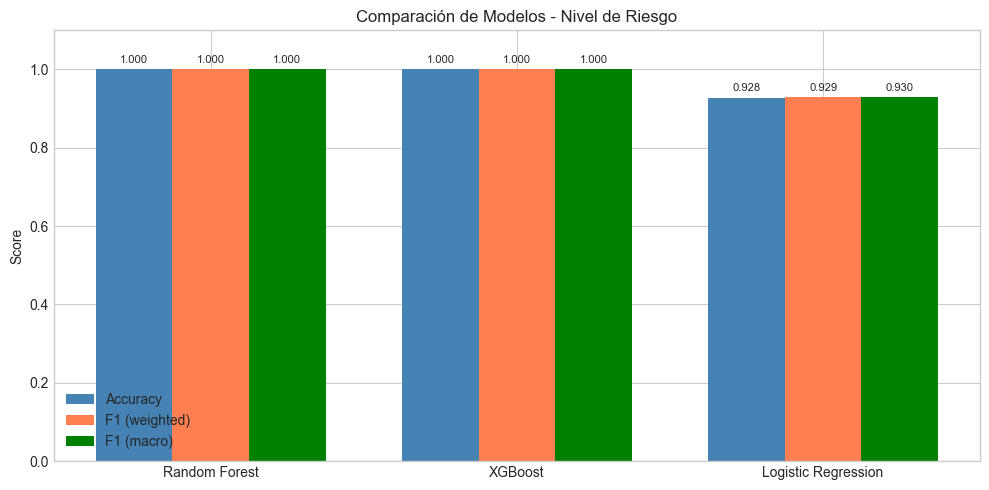


 Mejor modelo: Random Forest


In [14]:
# 4.2 Comparar modelos de riesgo
print("=" * 60)
print("COMPARACIÓN DE MODELOS - NIVEL DE RIESGO")
print("=" * 60)

# Crear DataFrame de resultados
df_results_riesgo = pd.DataFrame({
    'Modelo': list(resultados_riesgo.keys()),
    'Accuracy': [r['accuracy'] for r in resultados_riesgo.values()],
    'F1 (weighted)': [r['f1_weighted'] for r in resultados_riesgo.values()],
    'F1 (macro)': [r['f1_macro'] for r in resultados_riesgo.values()],
    'Tiempo (s)': [r['tiempo'] for r in resultados_riesgo.values()]
}).sort_values('F1 (weighted)', ascending=False)

print("\n Resultados:")
print(df_results_riesgo.to_string(index=False))

# Visualización
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(df_results_riesgo))
width = 0.25

bars1 = ax.bar(x - width, df_results_riesgo['Accuracy'], width, label='Accuracy', color='steelblue')
bars2 = ax.bar(x, df_results_riesgo['F1 (weighted)'], width, label='F1 (weighted)', color='coral')
bars3 = ax.bar(x + width, df_results_riesgo['F1 (macro)'], width, label='F1 (macro)', color='green')

ax.set_ylabel('Score')
ax.set_title('Comparación de Modelos - Nivel de Riesgo')
ax.set_xticks(x)
ax.set_xticklabels(df_results_riesgo['Modelo'])
ax.legend()
ax.set_ylim(0, 1.1)

for bars in [bars1, bars2, bars3]:
    ax.bar_label(bars, fmt='%.3f', padding=3, fontsize=8)

plt.tight_layout()
plt.show()

mejor_modelo_riesgo_nombre = df_results_riesgo.iloc[0]['Modelo']
print(f"\n Mejor modelo: {mejor_modelo_riesgo_nombre}")

EVALUACIÓN DETALLADA - RANDOM FOREST

 CLASSIFICATION REPORT:
--------------------------------------------------
              precision    recall  f1-score   support

        ALTO       1.00      1.00      1.00       812
        BAJO       1.00      1.00      1.00       851
       MEDIO       1.00      1.00      1.00       894

    accuracy                           1.00      2557
   macro avg       1.00      1.00      1.00      2557
weighted avg       1.00      1.00      1.00      2557



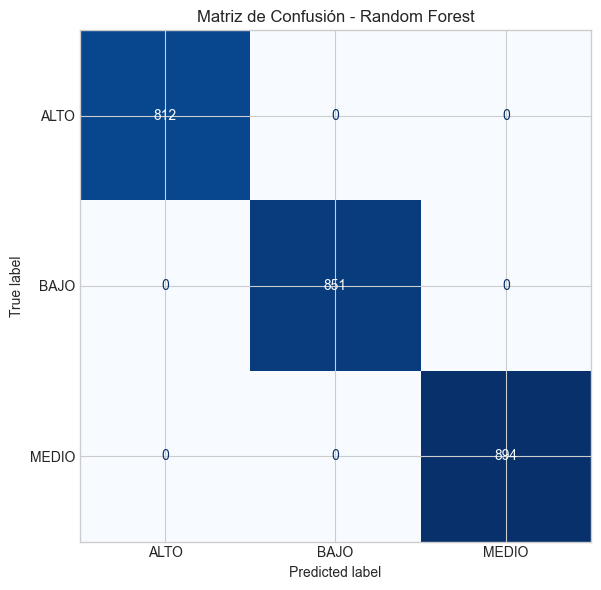

In [15]:
# 4.3 Evaluación detallada del mejor modelo de riesgo
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("=" * 60)
print(f"EVALUACIÓN DETALLADA - {mejor_modelo_riesgo_nombre.upper()}")
print("=" * 60)

mejor_modelo_riesgo = resultados_riesgo[mejor_modelo_riesgo_nombre]['modelo']
y_pred_riesgo = mejor_modelo_riesgo.predict(X_test_scaled)

# Classification Report
print(f"\n CLASSIFICATION REPORT:")
print("-" * 50)
print(classification_report(y_test_riesgo, y_pred_riesgo, 
                          target_names=le_riesgo.classes_,
                          zero_division=0))

# Matriz de confusión
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test_riesgo, y_pred_riesgo)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_riesgo.classes_)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title(f'Matriz de Confusión - {mejor_modelo_riesgo_nombre}')
plt.tight_layout()
plt.show()

FEATURE IMPORTANCE - NIVEL DE RIESGO

 Top 15 Features más importantes:
   total_delitos: 0.3551
   n_dias_laborales: 0.1014
   n_dias_semana: 0.0994
   roll_mean_3: 0.0831
   n_fines_de_semana: 0.0613
   LESIONES: 0.0591
   lag_1: 0.0474
   pct_change_1: 0.0308
   roll_std_3: 0.0194
   poblacion_total: 0.0177
   pct_change_3: 0.0176
   VIOLENCIA INTRAFAMILIAR: 0.0174
   HURTOS: 0.0162
   tasa_lesiones: 0.0107
   tasa_hurtos: 0.0099


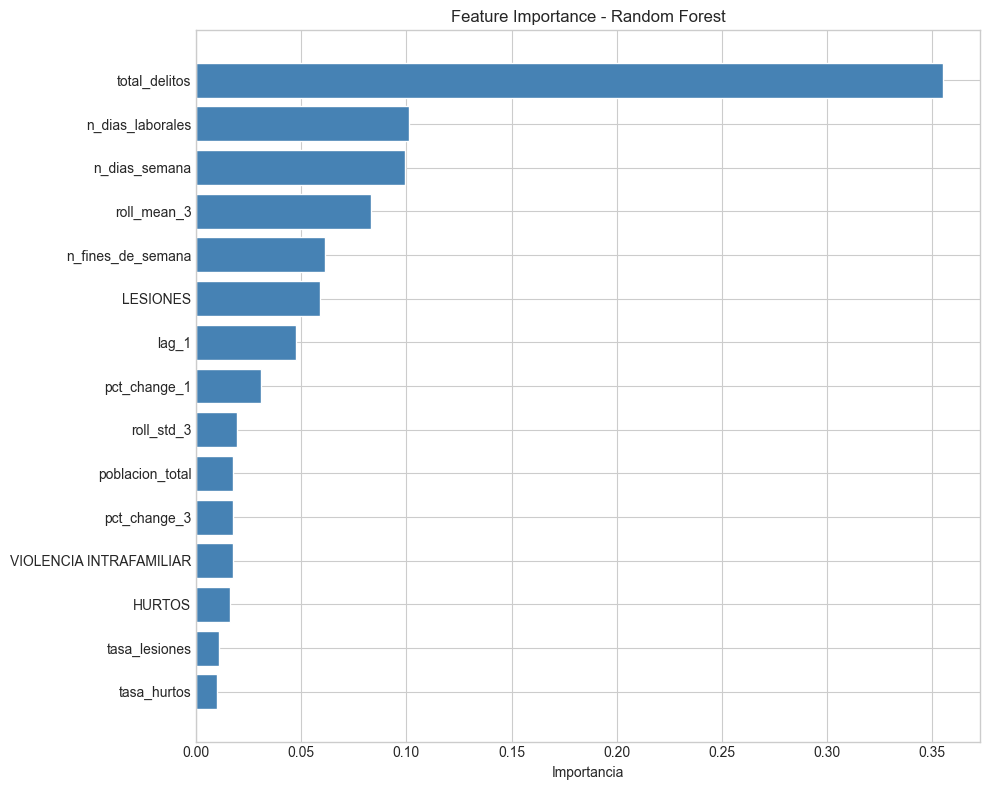

In [16]:
# 4.4 Feature Importance - Modelo Riesgo
print("=" * 60)
print("FEATURE IMPORTANCE - NIVEL DE RIESGO")
print("=" * 60)

if mejor_modelo_riesgo_nombre in ['Random Forest', 'XGBoost']:
    importances = mejor_modelo_riesgo.feature_importances_
    
    df_importance = pd.DataFrame({
        'Feature': FEATURE_COLS,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print(f"\n Top 15 Features más importantes:")
    for i, row in df_importance.head(15).iterrows():
        print(f"   {row['Feature']}: {row['Importance']:.4f}")
    
    # Visualización
    fig, ax = plt.subplots(figsize=(10, 8))
    top15 = df_importance.head(15)
    ax.barh(top15['Feature'], top15['Importance'], color='steelblue', edgecolor='white')
    ax.set_xlabel('Importancia')
    ax.set_title(f'Feature Importance - {mejor_modelo_riesgo_nombre}')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("El modelo seleccionado no tiene feature_importances_")

---
## 5. Modelo 2: Clasificación de Incremento de Delitos (Binario)

In [17]:
# 5.1 Preparar datos para modelo de incremento
print("=" * 60)
print("PREPARACIÓN - INCREMENTO DE DELITOS")
print("=" * 60)

# Eliminar nulos en incremento_delitos
mask_valid = y_train_incr.notna()
X_train_incr = X_train_scaled[mask_valid]
y_train_incr_clean = y_train_incr[mask_valid].astype(int)

mask_valid_test = y_test_incr.notna()
X_test_incr = X_test_scaled[mask_valid_test]
y_test_incr_clean = y_test_incr[mask_valid_test].astype(int)

print(f"\n Train (incremento): {len(X_train_incr):,} registros")
print(f" Test (incremento):  {len(X_test_incr):,} registros")

# Distribución
print(f"\n Distribución en train:")
print(f"   No incrementó (0): {(y_train_incr_clean == 0).sum():,}")
print(f"   Incrementó (1): {(y_train_incr_clean == 1).sum():,}")

PREPARACIÓN - INCREMENTO DE DELITOS

 Train (incremento): 10,226 registros
 Test (incremento):  2,557 registros

 Distribución en train:
   No incrementó (0): 5,894
   Incrementó (1): 4,332


In [18]:
# 5.2 Entrenar modelos para clasificación de incremento
from sklearn.metrics import roc_auc_score, precision_score, recall_score

print("=" * 60)
print("ENTRENAMIENTO - INCREMENTO DE DELITOS (Binario)")
print("=" * 60)

modelos_incr = {
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42, n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1,
                              eval_metric='logloss', verbosity=0)
}

resultados_incr = {}

for nombre, modelo in modelos_incr.items():
    print(f"\n Entrenando {nombre}...")
    start = time.time()
    
    modelo.fit(X_train_incr, y_train_incr_clean)
    y_pred = modelo.predict(X_test_incr)
    y_proba = modelo.predict_proba(X_test_incr)[:, 1]
    
    # Métricas
    acc = accuracy_score(y_test_incr_clean, y_pred)
    f1 = f1_score(y_test_incr_clean, y_pred)
    precision = precision_score(y_test_incr_clean, y_pred)
    recall = recall_score(y_test_incr_clean, y_pred)
    auc = roc_auc_score(y_test_incr_clean, y_proba)
    
    tiempo = time.time() - start
    
    resultados_incr[nombre] = {
        'modelo': modelo,
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'tiempo': tiempo
    }
    
    print(f"    Tiempo: {tiempo:.1f}s")
    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1: {f1:.4f}")
    print(f"    Precision: {precision:.4f}")
    print(f"    Recall: {recall:.4f}")
    print(f"    AUC: {auc:.4f}")

ENTRENAMIENTO - INCREMENTO DE DELITOS (Binario)

 Entrenando Logistic Regression...
    Tiempo: 1.3s
    Accuracy: 0.9859
    F1: 0.9829
    Precision: 0.9933
    Recall: 0.9728
    AUC: 0.9995

 Entrenando Random Forest...
    Tiempo: 0.2s
    Accuracy: 1.0000
    F1: 1.0000
    Precision: 1.0000
    Recall: 1.0000
    AUC: 1.0000

 Entrenando XGBoost...
    Tiempo: 0.1s
    Accuracy: 0.9996
    F1: 0.9995
    Precision: 0.9991
    Recall: 1.0000
    AUC: 1.0000


COMPARACIÓN DE MODELOS - INCREMENTO

 Resultados:
             Modelo  Accuracy       F1  Precision   Recall      AUC
      Random Forest  1.000000 1.000000   1.000000 1.000000 1.000000
            XGBoost  0.999609 0.999531   0.999063 1.000000 1.000000
Logistic Regression  0.985921 0.982938   0.993295 0.972795 0.999529


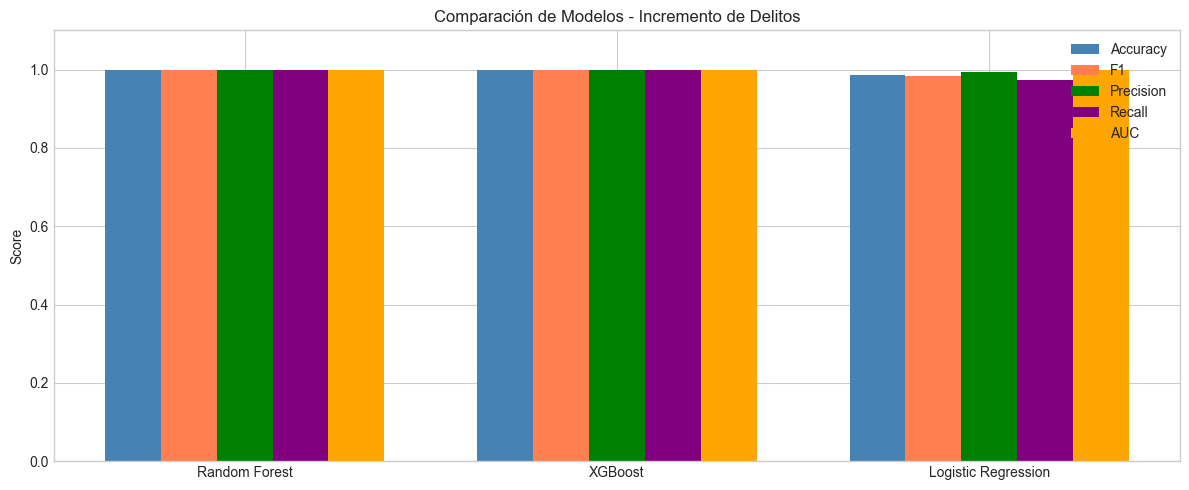


 Mejor modelo: Random Forest


In [19]:
# 5.3 Comparar modelos de incremento
print("=" * 60)
print("COMPARACIÓN DE MODELOS - INCREMENTO")
print("=" * 60)

df_results_incr = pd.DataFrame({
    'Modelo': list(resultados_incr.keys()),
    'Accuracy': [r['accuracy'] for r in resultados_incr.values()],
    'F1': [r['f1'] for r in resultados_incr.values()],
    'Precision': [r['precision'] for r in resultados_incr.values()],
    'Recall': [r['recall'] for r in resultados_incr.values()],
    'AUC': [r['auc'] for r in resultados_incr.values()],
}).sort_values('F1', ascending=False)

print("\n Resultados:")
print(df_results_incr.to_string(index=False))

# Visualización
fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(df_results_incr))
width = 0.15

metrics = ['Accuracy', 'F1', 'Precision', 'Recall', 'AUC']
colors = ['steelblue', 'coral', 'green', 'purple', 'orange']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    offset = (i - 2) * width
    bars = ax.bar(x + offset, df_results_incr[metric], width, label=metric, color=color)
    
ax.set_ylabel('Score')
ax.set_title('Comparación de Modelos - Incremento de Delitos')
ax.set_xticks(x)
ax.set_xticklabels(df_results_incr['Modelo'])
ax.legend()
ax.set_ylim(0, 1.1)
plt.tight_layout()
plt.show()

mejor_modelo_incr_nombre = df_results_incr.iloc[0]['Modelo']
print(f"\n Mejor modelo: {mejor_modelo_incr_nombre}")

EVALUACIÓN DETALLADA - RANDOM FOREST

 CLASSIFICATION REPORT:
--------------------------------------------------
               precision    recall  f1-score   support

No incrementó       1.00      1.00      1.00      1491
   Incrementó       1.00      1.00      1.00      1066

     accuracy                           1.00      2557
    macro avg       1.00      1.00      1.00      2557
 weighted avg       1.00      1.00      1.00      2557



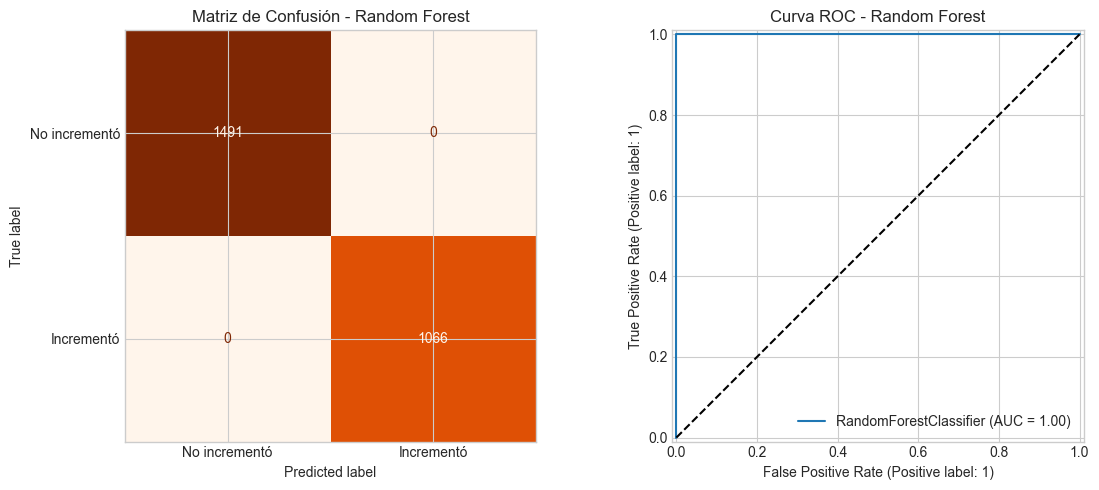

In [20]:
# 5.4 Evaluación detallada del mejor modelo de incremento
from sklearn.metrics import RocCurveDisplay

print("=" * 60)
print(f"EVALUACIÓN DETALLADA - {mejor_modelo_incr_nombre.upper()}")
print("=" * 60)

mejor_modelo_incr = resultados_incr[mejor_modelo_incr_nombre]['modelo']
y_pred_incr = mejor_modelo_incr.predict(X_test_incr)

# Classification Report
print(f"\n CLASSIFICATION REPORT:")
print("-" * 50)
print(classification_report(y_test_incr_clean, y_pred_incr,
                          target_names=['No incrementó', 'Incrementó'],
                          zero_division=0))

# Visualización: Matriz de confusión y curva ROC
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusión
ax1 = axes[0]
cm = confusion_matrix(y_test_incr_clean, y_pred_incr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No incrementó', 'Incrementó'])
disp.plot(ax=ax1, cmap='Oranges', colorbar=False)
ax1.set_title(f'Matriz de Confusión - {mejor_modelo_incr_nombre}')

# Curva ROC
ax2 = axes[1]
RocCurveDisplay.from_estimator(mejor_modelo_incr, X_test_incr, y_test_incr_clean, ax=ax2)
ax2.plot([0, 1], [0, 1], 'k--', label='Random')
ax2.set_title(f'Curva ROC - {mejor_modelo_incr_nombre}')

plt.tight_layout()
plt.show()

 TOP 15 CARACTERÍSTICAS MÁS IMPORTANTES - Random Forest


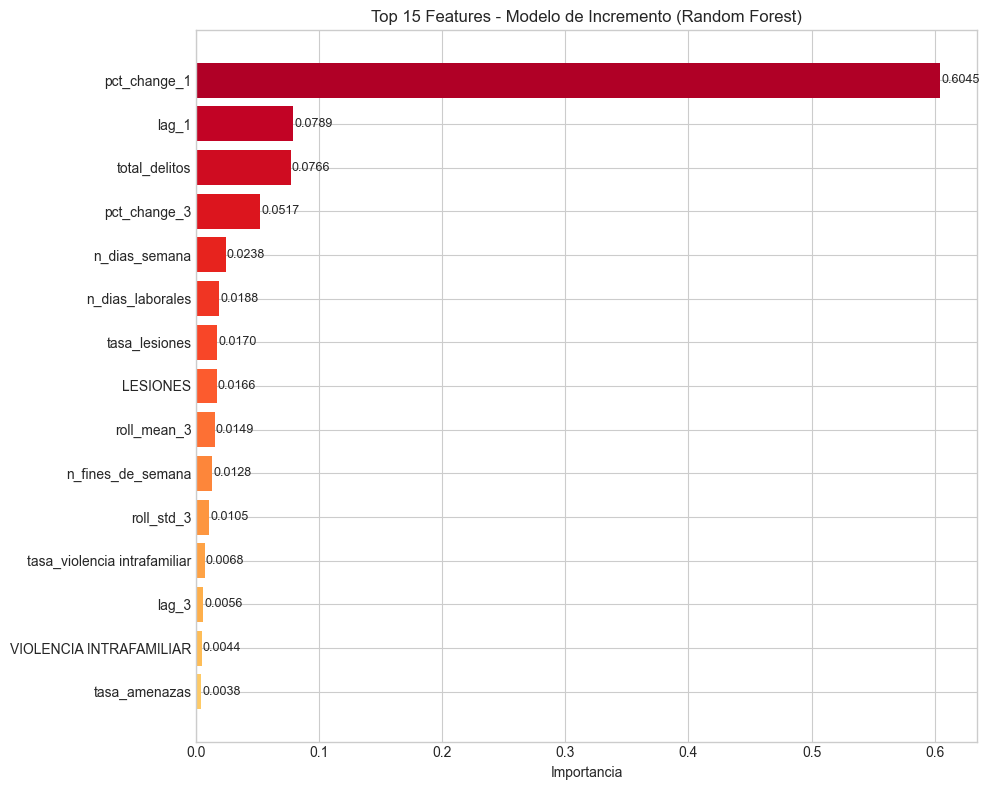


 Top 10 características:
   pct_change_1                             -> 0.6045
   lag_1                                    -> 0.0789
   total_delitos                            -> 0.0766
   pct_change_3                             -> 0.0517
   n_dias_semana                            -> 0.0238
   n_dias_laborales                         -> 0.0188
   tasa_lesiones                            -> 0.0170
   LESIONES                                 -> 0.0166
   roll_mean_3                              -> 0.0149
   n_fines_de_semana                        -> 0.0128


In [21]:
# 5.5 Importancia de características - Modelo de Incremento
if hasattr(mejor_modelo_incr, 'feature_importances_'):
    importancia_incr = pd.DataFrame({
        'feature': FEATURE_COLS,
        'importance': mejor_modelo_incr.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f" TOP 15 CARACTERÍSTICAS MÁS IMPORTANTES - {mejor_modelo_incr_nombre}")
    print("=" * 60)
    
    # Visualización
    fig, ax = plt.subplots(figsize=(10, 8))
    top_15_incr = importancia_incr.head(15)
    colors = plt.cm.YlOrRd(np.linspace(0.3, 0.9, 15))[::-1]
    bars = ax.barh(range(len(top_15_incr)), top_15_incr['importance'], color=colors)
    ax.set_yticks(range(len(top_15_incr)))
    ax.set_yticklabels(top_15_incr['feature'])
    ax.invert_yaxis()
    ax.set_xlabel('Importancia')
    ax.set_title(f'Top 15 Features - Modelo de Incremento ({mejor_modelo_incr_nombre})')
    
    # Añadir valores
    for i, (bar, val) in enumerate(zip(bars, top_15_incr['importance'])):
        ax.text(val + 0.001, i, f'{val:.4f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Tabla resumen
    print(f"\n Top 10 características:")
    for i, row in importancia_incr.head(10).iterrows():
        print(f"   {row['feature']:40s} -> {row['importance']:.4f}")
else:
    print("⚠️ El modelo seleccionado no tiene feature_importances_")

---

## 6. Optimización de Hiperparámetros

Usaremos **RandomizedSearchCV** para optimizar los mejores modelos de cada tarea.

In [22]:
# 6.1 Optimización del modelo de nivel de riesgo
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Definir espacio de búsqueda según el mejor modelo
param_distributions_riesgo = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

print(" OPTIMIZACIÓN - MODELO DE NIVEL DE RIESGO")
print("=" * 60)
print(f"Modelo base: {mejor_modelo_riesgo_nombre}")

# Crear nuevo modelo para optimizar
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Seleccionar modelo base según el mejor
if 'Random Forest' in mejor_modelo_riesgo_nombre:
    modelo_base_riesgo = RandomForestClassifier(random_state=42, n_jobs=-1)
elif 'Gradient' in mejor_modelo_riesgo_nombre:
    modelo_base_riesgo = GradientBoostingClassifier(random_state=42)
    param_distributions_riesgo = {
        'n_estimators': randint(100, 300),
        'max_depth': randint(3, 15),
        'learning_rate': uniform(0.01, 0.3),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10)
    }
else:
    modelo_base_riesgo = RandomForestClassifier(random_state=42, n_jobs=-1)

# RandomizedSearchCV
random_search_riesgo = RandomizedSearchCV(
    estimator=modelo_base_riesgo,
    param_distributions=param_distributions_riesgo,
    n_iter=30,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Ejecutando búsqueda de hiperparámetros...")
random_search_riesgo.fit(X_train_scaled, y_train_riesgo)

print(f"\n Mejores hiperparámetros encontrados:")
for param, value in random_search_riesgo.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n Mejor score CV (F1-macro): {random_search_riesgo.best_score_:.4f}")

 OPTIMIZACIÓN - MODELO DE NIVEL DE RIESGO
Modelo base: Random Forest
Ejecutando búsqueda de hiperparámetros...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

 Mejores hiperparámetros encontrados:
   max_depth: 20
   max_features: None
   min_samples_leaf: 8
   min_samples_split: 5
   n_estimators: 459

 Mejor score CV (F1-macro): 1.0000


📊 COMPARACIÓN: MODELO ORIGINAL vs OPTIMIZADO - RIESGO

Métrica                     Original      Optimizado          Mejora
-----------------------------------------------------------------
Accuracy                      1.0000          1.0000           0.00%
F1-Score (macro)              1.0000          1.0000           0.00%

⚠️ Se usará el modelo ORIGINAL (mejor rendimiento)


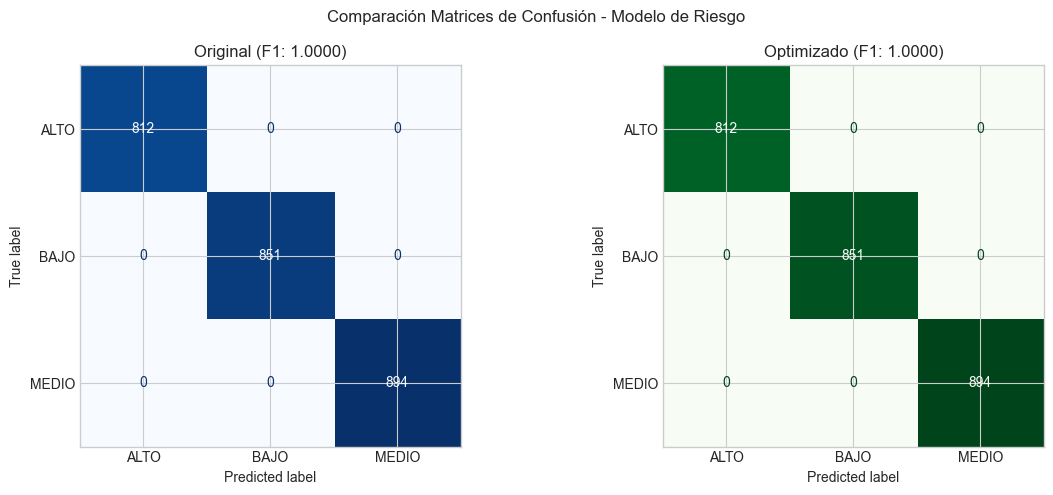

In [23]:
# 6.2 Evaluar modelo optimizado de riesgo
modelo_riesgo_optimizado = random_search_riesgo.best_estimator_
y_pred_riesgo_opt = modelo_riesgo_optimizado.predict(X_test_scaled)

print("📊 COMPARACIÓN: MODELO ORIGINAL vs OPTIMIZADO - RIESGO")
print("=" * 60)

# Métricas modelo original
y_pred_original = mejor_modelo_riesgo.predict(X_test_scaled)
acc_orig = accuracy_score(y_test_riesgo, y_pred_original)
f1_orig = f1_score(y_test_riesgo, y_pred_original, average='macro', zero_division=0)

# Métricas modelo optimizado
acc_opt = accuracy_score(y_test_riesgo, y_pred_riesgo_opt)
f1_opt = f1_score(y_test_riesgo, y_pred_riesgo_opt, average='macro', zero_division=0)

print(f"\n{'Métrica':<20} {'Original':>15} {'Optimizado':>15} {'Mejora':>15}")
print("-" * 65)
print(f"{'Accuracy':<20} {acc_orig:>15.4f} {acc_opt:>15.4f} {(acc_opt-acc_orig)*100:>14.2f}%")
print(f"{'F1-Score (macro)':<20} {f1_orig:>15.4f} {f1_opt:>15.4f} {(f1_opt-f1_orig)*100:>14.2f}%")

# Decidir cuál modelo usar
if f1_opt > f1_orig:
    modelo_riesgo_final = modelo_riesgo_optimizado
    print("\n✅ Se usará el modelo OPTIMIZADO")
else:
    modelo_riesgo_final = mejor_modelo_riesgo
    print("\n⚠️ Se usará el modelo ORIGINAL (mejor rendimiento)")

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusión original
cm_orig = confusion_matrix(y_test_riesgo, y_pred_original)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_orig, display_labels=le_riesgo.classes_)
disp1.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title(f'Original (F1: {f1_orig:.4f})')

# Matriz de confusión optimizado
cm_opt = confusion_matrix(y_test_riesgo, y_pred_riesgo_opt)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=le_riesgo.classes_)
disp2.plot(ax=axes[1], cmap='Greens', colorbar=False)
axes[1].set_title(f'Optimizado (F1: {f1_opt:.4f})')

plt.suptitle('Comparación Matrices de Confusión - Modelo de Riesgo', fontsize=12)
plt.tight_layout()
plt.show()

In [24]:
# 6.3 Optimización del modelo de incremento
print(" OPTIMIZACIÓN - MODELO DE INCREMENTO")
print("=" * 60)
print(f"Modelo base: {mejor_modelo_incr_nombre}")

# Definir espacio de búsqueda según el mejor modelo
if 'Random Forest' in mejor_modelo_incr_nombre:
    modelo_base_incr = RandomForestClassifier(random_state=42, n_jobs=-1)
    param_distributions_incr = {
        'n_estimators': randint(100, 500),
        'max_depth': [None, 10, 20, 30, 50],
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['sqrt', 'log2', None]
    }
elif 'Gradient' in mejor_modelo_incr_nombre:
    modelo_base_incr = GradientBoostingClassifier(random_state=42)
    param_distributions_incr = {
        'n_estimators': randint(100, 300),
        'max_depth': randint(3, 15),
        'learning_rate': uniform(0.01, 0.3),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10)
    }
else:
    modelo_base_incr = RandomForestClassifier(random_state=42, n_jobs=-1)
    param_distributions_incr = {
        'n_estimators': randint(100, 500),
        'max_depth': [None, 10, 20, 30, 50],
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10)
    }

# RandomizedSearchCV
random_search_incr = RandomizedSearchCV(
    estimator=modelo_base_incr,
    param_distributions=param_distributions_incr,
    n_iter=30,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Ejecutando búsqueda de hiperparámetros...")
random_search_incr.fit(X_train_incr, y_train_incr)

print(f"\n Mejores hiperparámetros encontrados:")
for param, value in random_search_incr.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n Mejor score CV (F1): {random_search_incr.best_score_:.4f}")

 OPTIMIZACIÓN - MODELO DE INCREMENTO
Modelo base: Random Forest
Ejecutando búsqueda de hiperparámetros...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

 Mejores hiperparámetros encontrados:
   max_depth: 20
   max_features: None
   min_samples_leaf: 8
   min_samples_split: 5
   n_estimators: 459

 Mejor score CV (F1): 1.0000


 COMPARACIÓN: MODELO ORIGINAL vs OPTIMIZADO - INCREMENTO

Métrica                     Original      Optimizado          Mejora
-----------------------------------------------------------------
Accuracy                      1.0000          1.0000           0.00%
F1-Score                      1.0000          1.0000           0.00%

⚠️ Se usará el modelo ORIGINAL (mejor rendimiento)


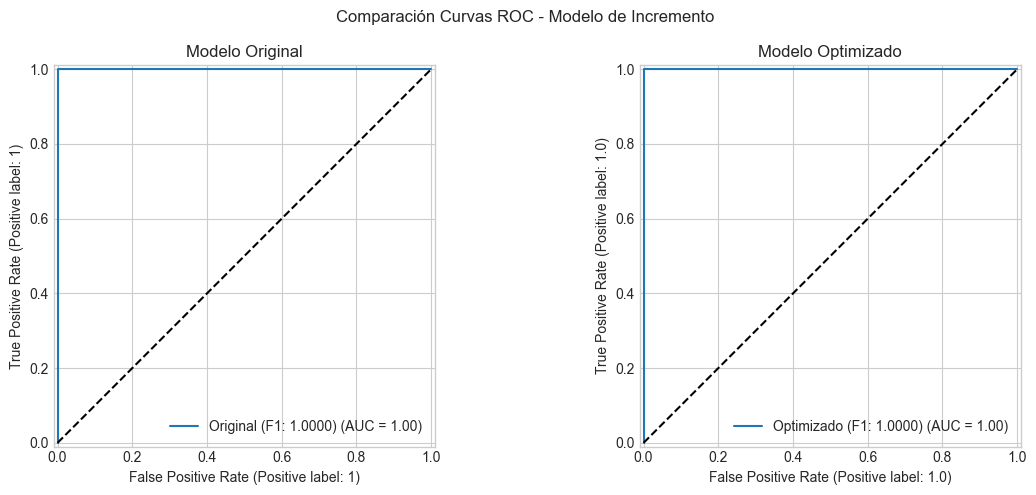

In [25]:
# 6.4 Evaluar modelo optimizado de incremento
modelo_incr_optimizado = random_search_incr.best_estimator_
y_pred_incr_opt = modelo_incr_optimizado.predict(X_test_incr)

print(" COMPARACIÓN: MODELO ORIGINAL vs OPTIMIZADO - INCREMENTO")
print("=" * 60)

# Métricas modelo original
y_pred_incr_orig = mejor_modelo_incr.predict(X_test_incr)
acc_orig_incr = accuracy_score(y_test_incr_clean, y_pred_incr_orig)
f1_orig_incr = f1_score(y_test_incr_clean, y_pred_incr_orig, zero_division=0)

# Métricas modelo optimizado
acc_opt_incr = accuracy_score(y_test_incr_clean, y_pred_incr_opt)
f1_opt_incr = f1_score(y_test_incr_clean, y_pred_incr_opt, zero_division=0)

print(f"\n{'Métrica':<20} {'Original':>15} {'Optimizado':>15} {'Mejora':>15}")
print("-" * 65)
print(f"{'Accuracy':<20} {acc_orig_incr:>15.4f} {acc_opt_incr:>15.4f} {(acc_opt_incr-acc_orig_incr)*100:>14.2f}%")
print(f"{'F1-Score':<20} {f1_orig_incr:>15.4f} {f1_opt_incr:>15.4f} {(f1_opt_incr-f1_orig_incr)*100:>14.2f}%")

# Decidir cuál modelo usar
if f1_opt_incr > f1_orig_incr:
    modelo_incr_final = modelo_incr_optimizado
    print("\n Se usará el modelo OPTIMIZADO")
else:
    modelo_incr_final = mejor_modelo_incr
    print("\n⚠️ Se usará el modelo ORIGINAL (mejor rendimiento)")

# Visualización comparativa con curvas ROC
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Curva ROC original
RocCurveDisplay.from_estimator(mejor_modelo_incr, X_test_incr, y_test_incr_clean, 
                               ax=axes[0], name=f'Original (F1: {f1_orig_incr:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_title('Modelo Original')

# Curva ROC optimizado
RocCurveDisplay.from_estimator(modelo_incr_optimizado, X_test_incr, y_test_incr_clean,
                               ax=axes[1], name=f'Optimizado (F1: {f1_opt_incr:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_title('Modelo Optimizado')

plt.suptitle('Comparación Curvas ROC - Modelo de Incremento', fontsize=12)
plt.tight_layout()
plt.show()

---

## 7. Guardar Modelos y Artefactos

Guardamos los modelos finales y sus componentes para uso en producción.

In [26]:
# 7.1 Crear estructura de directorios y guardar modelos
import joblib
import json
from datetime import datetime

# Directorio de salida
output_dir = Path('../models/predictivos/classification_monthly')
output_dir.mkdir(parents=True, exist_ok=True)

print(" GUARDANDO MODELOS Y ARTEFACTOS")
print("=" * 60)

# Guardar modelo de nivel de riesgo
riesgo_path = output_dir / 'modelo_nivel_riesgo.joblib'
joblib.dump(modelo_riesgo_final, riesgo_path)
print(f"✅ Modelo de riesgo guardado: {riesgo_path}")

# Guardar modelo de incremento
incr_path = output_dir / 'modelo_incremento.joblib'
joblib.dump(modelo_incr_final, incr_path)
print(f"✅ Modelo de incremento guardado: {incr_path}")

# Guardar scaler
scaler_path = output_dir / 'scaler.joblib'
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler guardado: {scaler_path}")

# Guardar label encoder
encoder_path = output_dir / 'label_encoder_riesgo.joblib'
joblib.dump(le_riesgo, encoder_path)
print(f"✅ Label Encoder guardado: {encoder_path}")

# Guardar lista de features
features_path = output_dir / 'feature_columns.json'
with open(features_path, 'w') as f:
    json.dump(FEATURE_COLS, f, indent=2)
print(f"✅ Lista de features guardada: {features_path}")

print(f"\n Archivos guardados en: {output_dir.absolute()}")

 GUARDANDO MODELOS Y ARTEFACTOS
✅ Modelo de riesgo guardado: ../models/predictivos/classification_monthly/modelo_nivel_riesgo.joblib
✅ Modelo de incremento guardado: ../models/predictivos/classification_monthly/modelo_incremento.joblib
✅ Scaler guardado: ../models/predictivos/classification_monthly/scaler.joblib
✅ Label Encoder guardado: ../models/predictivos/classification_monthly/label_encoder_riesgo.joblib
✅ Lista de features guardada: ../models/predictivos/classification_monthly/feature_columns.json

 Archivos guardados en: /Users/byverbel/quick_projects/Datos-al-Ecosistema/notebooks/../models/predictivos/classification_monthly


In [27]:
# 7.2 Guardar metadatos del modelo
metadata = {
    'fecha_entrenamiento': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset': 'classification_monthly_dataset.parquet',
    'n_muestras_train_riesgo': len(X_train_scaled),
    'n_muestras_test_riesgo': len(X_test_scaled),
    'n_muestras_train_incr': len(X_train_incr),
    'n_muestras_test_incr': len(X_test_incr),
    'n_features': len(FEATURE_COLS),
    'modelos': {
        'nivel_riesgo': {
            'tipo': type(modelo_riesgo_final).__name__,
            'clases': list(le_riesgo.classes_),
            'metricas': {
                'accuracy': float(accuracy_score(y_test_riesgo, modelo_riesgo_final.predict(X_test_scaled))),
                'f1_macro': float(f1_score(y_test_riesgo, modelo_riesgo_final.predict(X_test_scaled), average='macro', zero_division=0))
            },
            'hiperparametros_optimizados': random_search_riesgo.best_params_ if f1_opt > f1_orig else None
        },
        'incremento': {
            'tipo': type(modelo_incr_final).__name__,
            'clases': ['No incrementó', 'Incrementó'],
            'metricas': {
                'accuracy': float(accuracy_score(y_test_incr_clean, modelo_incr_final.predict(X_test_incr))),
                'f1': float(f1_score(y_test_incr_clean, modelo_incr_final.predict(X_test_incr), zero_division=0))
            },
            'hiperparametros_optimizados': random_search_incr.best_params_ if f1_opt_incr > f1_orig_incr else None
        }
    },
    'descripcion': {
        'nivel_riesgo': 'Clasifica municipios en BAJO, MEDIO o ALTO riesgo basado en patrones temporales de delitos',
        'incremento': 'Predice si el mes siguiente tendrá más delitos que el actual (incremento > 0)'
    }
}

# Convertir tipos numpy a python para JSON
def convert_numpy(obj):
    if hasattr(obj, 'item'):
        return obj.item()
    return obj

metadata_clean = json.loads(json.dumps(metadata, default=str))

metadata_path = output_dir / 'metadata.json'
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata_clean, f, indent=2, ensure_ascii=False)

print(" METADATOS DEL MODELO")
print("=" * 60)
print(json.dumps(metadata_clean, indent=2, ensure_ascii=False))

 METADATOS DEL MODELO
{
  "fecha_entrenamiento": "2025-11-28 22:12:27",
  "dataset": "classification_monthly_dataset.parquet",
  "n_muestras_train_riesgo": 10226,
  "n_muestras_test_riesgo": 2557,
  "n_muestras_train_incr": 10226,
  "n_muestras_test_incr": 2557,
  "n_features": 42,
  "modelos": {
    "nivel_riesgo": {
      "tipo": "RandomForestClassifier",
      "clases": [
        "ALTO",
        "BAJO",
        "MEDIO"
      ],
      "metricas": {
        "accuracy": 1.0,
        "f1_macro": 1.0
      },
      "hiperparametros_optimizados": null
    },
    "incremento": {
      "tipo": "RandomForestClassifier",
      "clases": [
        "No incrementó",
        "Incrementó"
      ],
      "metricas": {
        "accuracy": 1.0,
        "f1": 1.0
      },
      "hiperparametros_optimizados": null
    }
  },
  "descripcion": {
    "nivel_riesgo": "Clasifica municipios en BAJO, MEDIO o ALTO riesgo basado en patrones temporales de delitos",
    "incremento": "Predice si el mes siguiente 

---

## 8. Resumen y Uso del Modelo

### Archivos generados

| Archivo | Descripción |
|---------|-------------|
| `modelo_nivel_riesgo.joblib` | Modelo para clasificar nivel de riesgo (BAJO/MEDIO/ALTO) |
| `modelo_incremento.joblib` | Modelo para predecir incremento de delitos |
| `scaler.joblib` | StandardScaler para normalizar features |
| `label_encoder_riesgo.joblib` | Encoder para etiquetas de riesgo |
| `feature_columns.json` | Lista de columnas usadas como features |
| `metadata.json` | Metadatos del entrenamiento y métricas |

In [28]:
# 8.1 Ejemplo de uso del modelo
print("📖 EJEMPLO DE USO DEL MODELO")
print("=" * 60)

ejemplo_codigo = '''
import joblib
import json
import pandas as pd
import numpy as np

# Cargar artefactos
modelo_riesgo = joblib.load('models/predictivo/classification_monthly/modelo_nivel_riesgo.joblib')
modelo_incr = joblib.load('models/predictivo/classification_monthly/modelo_incremento.joblib')
scaler = joblib.load('models/predictivo/classification_monthly/scaler.joblib')
label_encoder = joblib.load('models/predictivo/classification_monthly/label_encoder_riesgo.joblib')

with open('models/predictivo/classification_monthly/feature_columns.json', 'r') as f:
    feature_cols = json.load(f)

# Preparar datos nuevos (ejemplo)
# Los datos deben tener las mismas columnas que feature_cols
datos_nuevos = pd.DataFrame({...})  # Tu DataFrame con datos del municipio

# Seleccionar features y escalar
X_nuevo = datos_nuevos[feature_cols].values
X_nuevo_scaled = scaler.transform(X_nuevo)

# Predicción de nivel de riesgo
riesgo_pred = modelo_riesgo.predict(X_nuevo_scaled)
riesgo_label = label_encoder.inverse_transform(riesgo_pred)
print(f"Nivel de riesgo: {riesgo_label[0]}")

# Predicción de incremento
incr_pred = modelo_incr.predict(X_nuevo_scaled)
incr_proba = modelo_incr.predict_proba(X_nuevo_scaled)
print(f"¿Incrementará delitos?: {'Sí' if incr_pred[0] == 1 else 'No'}")
print(f"Probabilidad de incremento: {incr_proba[0][1]:.2%}")
'''

print(ejemplo_codigo)

📖 EJEMPLO DE USO DEL MODELO

import joblib
import json
import pandas as pd
import numpy as np

# Cargar artefactos
modelo_riesgo = joblib.load('models/predictivo/classification_monthly/modelo_nivel_riesgo.joblib')
modelo_incr = joblib.load('models/predictivo/classification_monthly/modelo_incremento.joblib')
scaler = joblib.load('models/predictivo/classification_monthly/scaler.joblib')
label_encoder = joblib.load('models/predictivo/classification_monthly/label_encoder_riesgo.joblib')

with open('models/predictivo/classification_monthly/feature_columns.json', 'r') as f:
    feature_cols = json.load(f)

# Preparar datos nuevos (ejemplo)
# Los datos deben tener las mismas columnas que feature_cols
datos_nuevos = pd.DataFrame({...})  # Tu DataFrame con datos del municipio

# Seleccionar features y escalar
X_nuevo = datos_nuevos[feature_cols].values
X_nuevo_scaled = scaler.transform(X_nuevo)

# Predicción de nivel de riesgo
riesgo_pred = modelo_riesgo.predict(X_nuevo_scaled)
riesgo_label = l

In [29]:
# 8.2 Resumen final de rendimiento
print(" RESUMEN FINAL DE RENDIMIENTO")
print("=" * 60)

# Obtener predicciones finales
y_pred_riesgo_final = modelo_riesgo_final.predict(X_test_scaled)
y_pred_incr_final = modelo_incr_final.predict(X_test_incr)

# Métricas finales
from sklearn.metrics import balanced_accuracy_score

print("\n MODELO DE NIVEL DE RIESGO")
print("-" * 40)
print(f"   Tipo: {type(modelo_riesgo_final).__name__}")
print(f"   Accuracy: {accuracy_score(y_test_riesgo, y_pred_riesgo_final):.4f}")
print(f"   Balanced Accuracy: {balanced_accuracy_score(y_test_riesgo, y_pred_riesgo_final):.4f}")
print(f"   F1-Score (macro): {f1_score(y_test_riesgo, y_pred_riesgo_final, average='macro', zero_division=0):.4f}")
print(f"   F1-Score (weighted): {f1_score(y_test_riesgo, y_pred_riesgo_final, average='weighted', zero_division=0):.4f}")

print("\n MODELO DE INCREMENTO")
print("-" * 40)
print(f"   Tipo: {type(modelo_incr_final).__name__}")
print(f"   Accuracy: {accuracy_score(y_test_incr_clean, y_pred_incr_final):.4f}")
print(f"   Balanced Accuracy: {balanced_accuracy_score(y_test_incr_clean, y_pred_incr_final):.4f}")
print(f"   F1-Score: {f1_score(y_test_incr_clean, y_pred_incr_final, zero_division=0):.4f}")
print(f"   Precision: {precision_score(y_test_incr_clean, y_pred_incr_final, zero_division=0):.4f}")
print(f"   Recall: {recall_score(y_test_incr_clean, y_pred_incr_final, zero_division=0):.4f}")

print("\n" + "=" * 60)
print(" Entrenamiento completado exitosamente")
print(f" Modelos guardados en: models/predictivos/classification_monthly/")
print("=" * 60)

 RESUMEN FINAL DE RENDIMIENTO

 MODELO DE NIVEL DE RIESGO
----------------------------------------
   Tipo: RandomForestClassifier
   Accuracy: 1.0000
   Balanced Accuracy: 1.0000
   F1-Score (macro): 1.0000
   F1-Score (weighted): 1.0000

 MODELO DE INCREMENTO
----------------------------------------
   Tipo: RandomForestClassifier
   Accuracy: 1.0000
   Balanced Accuracy: 1.0000
   F1-Score: 1.0000
   Precision: 1.0000
   Recall: 1.0000

 Entrenamiento completado exitosamente
 Modelos guardados en: models/predictivos/classification_monthly/
